In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount = False)

Mounted at /content/drive


In [2]:
# extract data from zip file
import zipfile
import os

# Define the path to your zip file and the directory where you want to extract it
zip_file_path = '/content/drive/MyDrive/465 Project/new_archive.zip'
extract_folder_path = '/content/data'

os.makedirs(extract_folder_path, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder_path)

### Model : UCTransnet from Github

In [3]:
!pip install GitPython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 1.8 MB/s eta 0:00:00


In [4]:
import git

# URL of the repository
repo_url = 'https://github.com/NITR098/Awesome-U-Net.git'

# Path of the folder you want to clone
folder_path = 'models/_uctransnet'

# Initialize a Repo object with allowed unsafe options
repo = git.Repo.init('/content/uctransnet', mkdir=True)

# Configure sparse checkout settings
repo.config_writer().set_value("core", "sparseCheckout", "true").release()

# Define the remote
origin = repo.create_remote('origin', repo_url)

# Define sparse checkout paths
with open('/content/uctransnet/.git/info/sparse-checkout', 'w') as sc:
    sc.write(f'{folder_path}/*\n')

# Fetch the specific branch and depth for minimal history
origin.fetch(depth=1)

# Checkout the files from the fetched data
repo.git.checkout('FETCH_HEAD')

# Verify the files have been checked out
!ls -l /content/uctransnet/models/_uctransnet


total 36
-rw-r--r-- 1 root root  2154 Apr 22 23:05 Config.py
-rw-r--r-- 1 root root 17124 Apr 22 23:05 CTrans.py
-rw-r--r-- 1 root root  5203 Apr 22 23:05 UCTransNet.py
-rw-r--r-- 1 root root  3971 Apr 22 23:05 UNet.py


In [5]:
!wget https://raw.githubusercontent.com/NITR098/Awesome-U-Net/main/models/__init__.py -P /content/uctransnet/models/_uctransnet

--2024-04-22 23:05:49--  https://raw.githubusercontent.com/NITR098/Awesome-U-Net/main/models/__init__.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 0 [text/plain]
Saving to: ‘/content/uctransnet/models/_uctransnet/__init__.py’

__init__.py             [ <=>                ]       0  --.-KB/s    in 0s      

2024-04-22 23:05:49 (0.00 B/s) - ‘/content/uctransnet/models/_uctransnet/__init__.py’ saved [0/0]



In [6]:
!pip install ml-collections

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 859.5 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ml-collections: filename=ml_collections-0.1.1-py3-none-any.whl size=94506 sha256=f7400116c6478f2abbb0b99ab38ee36017f9168841b498711547d1039e24f8d3
  Stored in directory: /root/.cache/pip/wheels/7b/89/c9/a9b87790789e94aadcfc393c283e3ecd5ab916aed0a31be8fe
Successfully built ml-collections


In [7]:
import sys
sys.path.append('/content/uctransnet/models')  # Add the models directory to sys.path

from _uctransnet.UCTransNet import UCTransNet
from _uctransnet.Config import get_CTranS_config


In [14]:
# # Set up environment variables and seeds as specified in Config.py
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # This line may be redundant in Colab
torch.manual_seed(666)
torch.cuda.manual_seed_all(666)
np.random.seed(666)
random.seed(666)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [15]:
config = get_CTranS_config()
model = UCTransNet(config, n_channels=3, n_classes=1, img_size=224)


In [16]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


### Imports

In [11]:
# lib imports
import torch
import os
import numpy as np
import pandas as pd
import random
import cv2

from tqdm import tqdm

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

In [12]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
IMG_CHANNELS = 3
IMG_COUNT = 480

In [13]:
# set this between [1, 10] for differently composed datasets
# reference: https://arxiv.org/pdf/2307.05911.pdf
TRAINING_SET = 1

# TestSets

In [17]:
#@title This cell is for composing the datasets as mentioned in the original paper

# Set the target image size
target_size = (IMG_WIDTH, IMG_HEIGHT)

# Create empty lists to hold the images and masks
images = []
masks = []

image_dir_ms = '/content/data/GRAIN DATA SET/RG'
mask_dir_ms = '/content/data/GRAIN DATA SET/RGMask'
# vt stands for voronoi tessellation
image_dir_vt = '/content/data/GRAIN DATA SET/AG'
mask_dir_vt = '/content/data/GRAIN DATA SET/AGMask'

image_dir_hed = '/content/data/GRAIN DATA SET/HED_PRE'
mask_dir_hed = '/content/data/GRAIN DATA SET/RGMask'

image_dir_grad = '/content/data/GRAIN DATA SET/GRAD_PRE'
mask_dir_grad = '/content/data/GRAIN DATA SET/RGMask'

image_dir_thresh = '/content/data/GRAIN DATA SET/THRESH_PRE'
mask_dir_thresh = '/content/data/GRAIN DATA SET/RGMask'

if TRAINING_SET==1:
    # 100% Manually Segmented
    print("Selected Training Set 1")
    print("Manually Segmented - 100% (480)")
    # Iterate through the directories and load the images and masks
    for file in sorted(os.listdir(image_dir_ms)):
        # Load the image and resize to the target size
        img = cv2.imread(os.path.join(image_dir_ms, file))
        img = cv2.resize(img, target_size)

        # Append the resized image to the list of images
        images.append(img)

    for file in sorted(os.listdir(mask_dir_ms)):

        # Load the corresponding mask and resize to the target size
        mask = cv2.imread(os.path.join(mask_dir_ms, file))
        mask = cv2.resize(mask, target_size)

        # Append the resized mask to the list of masks
        masks.append(mask)

elif TRAINING_SET==2:
    # 25% Artificial, 75% Manually Segmented (160, 480)
    print("Selected Training Set 2")
    print("Voronoi Tessellation - 25% (160)")
    print("Manually Segmented - 75% (480)")
    # Iterate through the directories and load the images and masks
    for file in sorted(os.listdir(image_dir_ms)):
        # Load the image and resize to the target size
        img = cv2.imread(os.path.join(image_dir_ms, file))
        img = cv2.resize(img, target_size)

        # Append the resized image to the list of images
        images.append(img)

    for file in sorted(os.listdir(mask_dir_ms)):

        # Load the corresponding mask and resize to the target size
        mask = cv2.imread(os.path.join(mask_dir_ms, file))
        mask = cv2.resize(mask, target_size)

        # Append the resized mask to the list of masks
        masks.append(mask)

    cnt = 0
    # Iterate through the directories and load the images and masks
    for file in sorted(os.listdir(image_dir_vt)):
        if cnt==160:
            break
        # Load the image and resize to the target size
        img = cv2.imread(os.path.join(image_dir_vt, file))
        img = cv2.resize(img, target_size)

        # Append the resized image to the list of images
        images.append(img)
        cnt+=1

    cnt=0
    for file in sorted(os.listdir(mask_dir_vt)):
        if cnt==160:
            break
        # Load the corresponding mask and resize to the target size
        mask = cv2.imread(os.path.join(mask_dir_vt, file))
        mask = cv2.resize(mask, target_size)

        # Append the resized mask to the list of masks
        masks.append(mask)
        cnt+=1

elif TRAINING_SET==3:
    # 50% Artificial, 50% Manually Segmented (480, 480)
    print("Selected Training Set 3")
    print("Voronoi Tessellation - 50% (480)")
    print("Manually Segmented - 50% (480)")
    # Iterate through the directories and load the images and masks
    for file in sorted(os.listdir(image_dir_ms)):
        # Load the image and resize to the target size
        img = cv2.imread(os.path.join(image_dir_ms, file))
        img = cv2.resize(img, target_size)

        # Append the resized image to the list of images
        images.append(img)

    for file in sorted(os.listdir(mask_dir_ms)):

        # Load the corresponding mask and resize to the target size
        mask = cv2.imread(os.path.join(mask_dir_ms, file))
        mask = cv2.resize(mask, target_size)

        # Append the resized mask to the list of masks
        masks.append(mask)

    cnt = 0
    # Iterate through the directories and load the images and masks
    for file in sorted(os.listdir(image_dir_vt)):
        if cnt==480:
            break
        # Load the image and resize to the target size
        img = cv2.imread(os.path.join(image_dir_vt, file))
        img = cv2.resize(img, target_size)

        # Append the resized image to the list of images
        images.append(img)
        cnt+=1

    cnt=0
    for file in sorted(os.listdir(mask_dir_vt)):
        if cnt==480:
            break
        # Load the corresponding mask and resize to the target size
        mask = cv2.imread(os.path.join(mask_dir_vt, file))
        mask = cv2.resize(mask, target_size)

        # Append the resized mask to the list of masks
        masks.append(mask)
        cnt+=1

elif TRAINING_SET==4:
    # 75% Artificial, 25% Manually Segmented (800, 266)
    print("Selected Training Set 4")
    print("Voronoi Tessellation - 75% (800)")
    print("Manually Segmented - 25% (266)")
    cnt = 0
    # Iterate through the directories and load the images and masks
    for file in sorted(os.listdir(image_dir_ms)):
        if cnt==266:
            break
        # Load the image and resize to the target size
        img = cv2.imread(os.path.join(image_dir_ms, file))
        img = cv2.resize(img, target_size)

        # Append the resized image to the list of images
        images.append(img)
        cnt+=1

    cnt=0
    for file in sorted(os.listdir(mask_dir_ms)):
        if cnt==266:
            break
        # Load the corresponding mask and resize to the target size
        mask = cv2.imread(os.path.join(mask_dir_ms, file))
        mask = cv2.resize(mask, target_size)

        # Append the resized mask to the list of masks
        masks.append(mask)
        cnt+=1

    # Iterate through the directories and load the images and masks
    for file in sorted(os.listdir(image_dir_vt)):
        # Load the image and resize to the target size
        img = cv2.imread(os.path.join(image_dir_vt, file))
        img = cv2.resize(img, target_size)

        # Append the resized image to the list of images
        images.append(img)

    for file in sorted(os.listdir(mask_dir_vt)):

        # Load the corresponding mask and resize to the target size
        mask = cv2.imread(os.path.join(mask_dir_vt, file))
        mask = cv2.resize(mask, target_size)

        # Append the resized mask to the list of masks
        masks.append(mask)

elif TRAINING_SET==5:
    # 100% Artificial (800)
    print("Selected Training Set 5")
    print("Voronoi Tessellation - 100% (800)")
    # Iterate through the directories and load the images and masks
    for file in sorted(os.listdir(image_dir_vt)):
        # Load the image and resize to the target size
        img = cv2.imread(os.path.join(image_dir_vt, file))
        img = cv2.resize(img, target_size)

        # Append the resized image to the list of images
        images.append(img)

    for file in sorted(os.listdir(mask_dir_vt)):

        # Load the corresponding mask and resize to the target size
        mask = cv2.imread(os.path.join(mask_dir_vt, file))
        mask = cv2.resize(mask, target_size)

        # Append the resized mask to the list of masks
        masks.append(mask)

elif TRAINING_SET==6:
    # 50% HED Preprocessed, 50% Manually Segmented (240, 240)
    print("Selected Training Set 6")
    print("HED Preprocessed - 50% (240)")
    print("Manually Segmented - 50% (240)")
    cnt = 0
    # Iterate through the directories and load the images and masks
    for file in sorted(os.listdir(image_dir_ms)):
        if cnt==240:
            break
        # Load the image and resize to the target size
        img = cv2.imread(os.path.join(image_dir_ms, file))
        img = cv2.resize(img, target_size)

        # Append the resized image to the list of images
        images.append(img)
        cnt+=1

    cnt=0
    for file in sorted(os.listdir(mask_dir_ms)):
        if cnt==240:
            break
        # Load the corresponding mask and resize to the target size
        mask = cv2.imread(os.path.join(mask_dir_ms, file))
        mask = cv2.resize(mask, target_size)

        # Append the resized mask to the list of masks
        masks.append(mask)
        cnt+=1

    cnt = 0
    # Iterate through the directories and load the images and masks
    for file in sorted(os.listdir(image_dir_hed)):
        if cnt<240:
            cnt+=1
            continue
        if cnt==480:
            break
        # Load the image and resize to the target size
        img = cv2.imread(os.path.join(image_dir_hed, file))
        img = cv2.resize(img, target_size)

        # Append the resized image to the list of images
        images.append(img)
        cnt+=1

    cnt=0
    for file in sorted(os.listdir(mask_dir_hed)):
        if cnt<240:
            cnt+=1
            continue
        if cnt==480:
            break
        # Load the corresponding mask and resize to the target size
        mask = cv2.imread(os.path.join(mask_dir_hed, file))
        mask = cv2.resize(mask, target_size)

        # Append the resized mask to the list of masks
        masks.append(mask)
        cnt+=1

elif TRAINING_SET==7:
    # 50% Manually Segmented, 25% Artificial, 25% HED Preprocessed(240, 120, 120)
    print("Selected Training Set 7")
    print("Manually Segmented - 50% (240)")
    print("Voronoi Tessellation - 25% (120)")
    print("HED Preprocessed - 25% (120)")
    # Iterate through the directories and load the images and masks
    cnt=0
    for file in sorted(os.listdir(image_dir_ms)):
        if cnt==240:
            break
        # Load the image and resize to the target size
        img = cv2.imread(os.path.join(image_dir_ms, file))
        img = cv2.resize(img, target_size)

        # Append the resized image to the list of images
        images.append(img)
        cnt+=1

    cnt=0
    for file in sorted(os.listdir(mask_dir_ms)):
        if cnt==240:
            break
        # Load the corresponding mask and resize to the target size
        mask = cv2.imread(os.path.join(mask_dir_ms, file))
        mask = cv2.resize(mask, target_size)

        # Append the resized mask to the list of masks
        masks.append(mask)
        cnt+=1


    cnt = 0
    # Iterate through the directories and load the images and masks
    for file in sorted(os.listdir(image_dir_vt)):
        if cnt==120:
            break
        # Load the image and resize to the target size
        img = cv2.imread(os.path.join(image_dir_vt, file))
        img = cv2.resize(img, target_size)

        # Append the resized image to the list of images
        images.append(img)
        cnt+=1

    cnt=0
    for file in sorted(os.listdir(mask_dir_vt)):
        if cnt==120:
            break
        # Load the corresponding mask and resize to the target size
        mask = cv2.imread(os.path.join(mask_dir_vt, file))
        mask = cv2.resize(mask, target_size)

        # Append the resized mask to the list of masks
        masks.append(mask)
        cnt+=1


    cnt = 0
    # Iterate through the directories and load the images and masks
    for file in sorted(os.listdir(image_dir_hed)):
        if cnt<240:
            cnt+=1
            continue
        if cnt==360:
            break
        # Load the image and resize to the target size
        img = cv2.imread(os.path.join(image_dir_hed, file))
        img = cv2.resize(img, target_size)

        # Append the resized image to the list of images
        images.append(img)
        cnt+=1

    cnt=0
    for file in sorted(os.listdir(mask_dir_hed)):
        if cnt<240:
            cnt+=1
            continue
        if cnt==360:
            break
        # Load the corresponding mask and resize to the target size
        mask = cv2.imread(os.path.join(mask_dir_hed, file))
        mask = cv2.resize(mask, target_size)

        # Append the resized mask to the list of masks
        masks.append(mask)
        cnt+=1


elif TRAINING_SET==8:
    # 50% Manually Segmented, 25% Artificial, 25% GRAD Preprocessed(240, 120, 120)
    print("Selected Training Set 8")
    print("Manually Segmented - 50% (240)")
    print("Voronoi Tessellation - 25% (120)")
    print("GRAD Preprocessed - 25% (120)")
    # Iterate through the directories and load the images and masks
    cnt=0
    for file in sorted(os.listdir(image_dir_ms)):
        if cnt==240:
            break
        # Load the image and resize to the target size
        img = cv2.imread(os.path.join(image_dir_ms, file))
        img = cv2.resize(img, target_size)

        # Append the resized image to the list of images
        images.append(img)
        cnt+=1

    cnt=0
    for file in sorted(os.listdir(mask_dir_ms)):
        if cnt==240:
            break
        # Load the corresponding mask and resize to the target size
        mask = cv2.imread(os.path.join(mask_dir_ms, file))
        mask = cv2.resize(mask, target_size)

        # Append the resized mask to the list of masks
        masks.append(mask)
        cnt+=1


    cnt = 0
    # Iterate through the directories and load the images and masks
    for file in sorted(os.listdir(image_dir_vt)):
        if cnt==120:
            break
        # Load the image and resize to the target size
        img = cv2.imread(os.path.join(image_dir_vt, file))
        img = cv2.resize(img, target_size)

        # Append the resized image to the list of images
        images.append(img)
        cnt+=1

    cnt=0
    for file in sorted(os.listdir(mask_dir_vt)):
        if cnt==120:
            break
        # Load the corresponding mask and resize to the target size
        mask = cv2.imread(os.path.join(mask_dir_vt, file))
        mask = cv2.resize(mask, target_size)

        # Append the resized mask to the list of masks
        masks.append(mask)
        cnt+=1


    cnt = 0
    # Iterate through the directories and load the images and masks
    for file in sorted(os.listdir(image_dir_grad)):
        if cnt<240:
            cnt+=1
            continue
        if cnt==360:
            break
        # Load the image and resize to the target size
        img = cv2.imread(os.path.join(image_dir_grad, file))
        img = cv2.resize(img, target_size)

        # Append the resized image to the list of images
        images.append(img)
        cnt+=1

    cnt=0
    for file in sorted(os.listdir(mask_dir_grad)):
        if cnt<240:
            cnt+=1
            continue
        if cnt==360:
            break
        # Load the corresponding mask and resize to the target size
        mask = cv2.imread(os.path.join(mask_dir_grad, file))
        mask = cv2.resize(mask, target_size)

        # Append the resized mask to the list of masks
        masks.append(mask)
        cnt+=1

elif TRAINING_SET==9:
    # 50% Manually Segmented, 25% Artificial, 25% THRESHOLD Preprocessed(240, 120, 120)
    print("Selected Training Set 9")
    print("Manually Segmented - 50% (240)")
    print("Voronoi Tessellation - 25% (120)")
    print("THRESHOLD Preprocessed - 25% (120)")
    # Iterate through the directories and load the images and masks
    cnt=0
    for file in sorted(os.listdir(image_dir_ms)):
        if cnt==240:
            break
        # Load the image and resize to the target size
        img = cv2.imread(os.path.join(image_dir_ms, file))
        img = cv2.resize(img, target_size)

        # Append the resized image to the list of images
        images.append(img)
        cnt+=1

    cnt=0
    for file in sorted(os.listdir(mask_dir_ms)):
        if cnt==240:
            break
        # Load the corresponding mask and resize to the target size
        mask = cv2.imread(os.path.join(mask_dir_ms, file))
        mask = cv2.resize(mask, target_size)

        # Append the resized mask to the list of masks
        masks.append(mask)
        cnt+=1


    cnt = 0
    # Iterate through the directories and load the images and masks
    for file in sorted(os.listdir(image_dir_vt)):
        if cnt==120:
            break
        # Load the image and resize to the target size
        img = cv2.imread(os.path.join(image_dir_vt, file))
        img = cv2.resize(img, target_size)

        # Append the resized image to the list of images
        images.append(img)
        cnt+=1

    cnt=0
    for file in sorted(os.listdir(mask_dir_vt)):
        if cnt==120:
            break
        # Load the corresponding mask and resize to the target size
        mask = cv2.imread(os.path.join(mask_dir_vt, file))
        mask = cv2.resize(mask, target_size)

        # Append the resized mask to the list of masks
        masks.append(mask)
        cnt+=1


    cnt = 0
    # Iterate through the directories and load the images and masks
    for file in sorted(os.listdir(image_dir_thresh)):
        if cnt<240:
            cnt+=1
            continue
        if cnt==360:
            break
        # Load the image and resize to the target size
        img = cv2.imread(os.path.join(image_dir_thresh, file))
        img = cv2.resize(img, target_size)

        # Append the resized image to the list of images
        images.append(img)
        cnt+=1

    cnt=0
    for file in sorted(os.listdir(mask_dir_thresh)):
        if cnt<240:
            cnt+=1
            continue
        if cnt==360:
            break
        # Load the corresponding mask and resize to the target size
        mask = cv2.imread(os.path.join(mask_dir_thresh, file))
        mask = cv2.resize(mask, target_size)

        # Append the resized mask to the list of masks
        masks.append(mask)
        cnt+=1

elif TRAINING_SET==10:
    # 50% Manually Segmented, 16.67% HED Prep., 16.67% GRAD Prep.,16.67% THRESHOLD Prep.(240, 80, 80, 80)
    print("Selected Training Set 10")
    print("Manually Segmented - 50% (240)")
    print("HED Preprocessed - 16.67% (80)")
    print("GRAD Preprocessed - 16.67% (80)")
    print("THRESHOLD Preprocessed - 16.67% (80)")
    # Iterate through the directories and load the images and masks
    cnt=0
    for file in sorted(os.listdir(image_dir_ms)):
        if cnt==240:
            break
        # Load the image and resize to the target size
        img = cv2.imread(os.path.join(image_dir_ms, file))
        img = cv2.resize(img, target_size)

        # Append the resized image to the list of images
        images.append(img)
        cnt+=1

    cnt=0
    for file in sorted(os.listdir(mask_dir_ms)):
        if cnt==240:
            break
        # Load the corresponding mask and resize to the target size
        mask = cv2.imread(os.path.join(mask_dir_ms, file))
        mask = cv2.resize(mask, target_size)

        # Append the resized mask to the list of masks
        masks.append(mask)
        cnt+=1

    cnt = 0
    # Iterate through the directories and load the images and masks
    for file in sorted(os.listdir(image_dir_hed)):
        if cnt<240:
            cnt+=1
            continue
        if cnt==320:
            break
        # Load the image and resize to the target size
        img = cv2.imread(os.path.join(image_dir_hed, file))
        img = cv2.resize(img, target_size)

        # Append the resized image to the list of images
        images.append(img)
        cnt+=1

    cnt=0
    for file in sorted(os.listdir(mask_dir_hed)):
        if cnt<240:
            cnt+=1
            continue
        if cnt==320:
            break
        # Load the corresponding mask and resize to the target size
        mask = cv2.imread(os.path.join(mask_dir_hed, file))
        mask = cv2.resize(mask, target_size)

        # Append the resized mask to the list of masks
        masks.append(mask)
        cnt+=1

    cnt = 0
    # Iterate through the directories and load the images and masks
    for file in sorted(os.listdir(image_dir_grad)):
        if cnt<320:
            cnt+=1
            continue
        if cnt==400:
            break
        # Load the image and resize to the target size
        img = cv2.imread(os.path.join(image_dir_grad, file))
        img = cv2.resize(img, target_size)

        # Append the resized image to the list of images
        images.append(img)
        cnt+=1

    cnt=0
    for file in sorted(os.listdir(mask_dir_grad)):
        if cnt<320:
            cnt+=1
            continue
        if cnt==400:
            break
        # Load the corresponding mask and resize to the target size
        mask = cv2.imread(os.path.join(mask_dir_grad, file))
        mask = cv2.resize(mask, target_size)

        # Append the resized mask to the list of masks
        masks.append(mask)
        cnt+=1

    cnt = 0
    # Iterate through the directories and load the images and masks
    for file in sorted(os.listdir(image_dir_thresh)):
        if cnt<400:
            cnt+=1
            continue
        if cnt==480:
            break
        # Load the image and resize to the target size
        img = cv2.imread(os.path.join(image_dir_thresh, file))
        img = cv2.resize(img, target_size)

        # Append the resized image to the list of images
        images.append(img)
        cnt+=1

    cnt=0
    for file in sorted(os.listdir(mask_dir_thresh)):
        if cnt<400:
            cnt+=1
            continue
        if cnt==480:
            break
        # Load the corresponding mask and resize to the target size
        mask = cv2.imread(os.path.join(mask_dir_thresh, file))
        mask = cv2.resize(mask, target_size)

        # Append the resized mask to the list of masks
        masks.append(mask)
        cnt+=1



IMG_COUNT = len(images)
print(f"image count : {IMG_COUNT}")

Selected Training Set 1
Manually Segmented - 100% (480)
image count : 480


# Example Image and it's Ground Truth

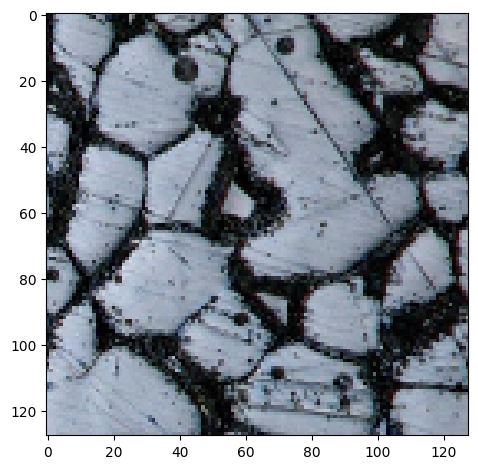

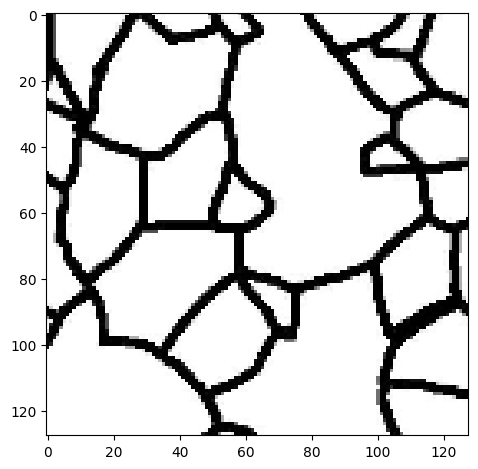

In [ ]:
# example
image_x = random.randint(0, IMG_COUNT)
image_x
imshow(images[image_x])
plt.show()
imshow(masks[image_x])
plt.show()

# Dataset splitting

In [18]:
# create the X and Y (input and output)

X_train = np.array(images)
Y_train = np.array(masks)
print(X_train.shape, Y_train.shape)
# change the Y to a boolean
Y_train = np.where(Y_train > 245, True, False)

(480, 224, 224, 3) (480, 224, 224, 3)


In [19]:
# careful to run this cell only once (otherwise shape changes)
X_train = np.transpose(X_train, (0, 3, 1 , 2))
Y_train = np.transpose(Y_train, (0, 3, 1 , 2))
print(X_train.shape, Y_train.shape)

(480, 3, 224, 224) (480, 3, 224, 224)


In [20]:
#convert the boolean where it insion s true (any of the 3 channels) to a (336, 128, 128, 1)
#basically reduce the 3 channel dimeRGB to just one boolean value

Y_t= np.any(Y_train, axis=1)
print(Y_t.shape)
Y_t = Y_t.reshape(IMG_COUNT, 1, IMG_WIDTH, IMG_WIDTH)
print(Y_t.shape)


(480, 224, 224)
(480, 1, 224, 224)


In [21]:
# prompt: Make Dataset from data

from torch.utils.data import Dataset

class GrainDataset(Dataset):
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = torch.from_numpy(self.images[idx]).float()
        mask = torch.from_numpy(self.masks[idx]).float()
        return image, mask

# Create the dataset
dataset = GrainDataset(X_train, Y_t)



In [22]:
# prompt: create train and validation dataset

from torch.utils.data import random_split

# Split the dataset into train and validation sets (80-10-10)
train_size = int(0.80 * len(dataset))
r = len(dataset) - train_size
val_size = int(0.5 * r)
test_size = int(0.5 * r)
train_dataset, val_dataset,test_dataset = random_split(dataset, [train_size, val_size, test_size])



In [23]:
print(f"Train : {train_size}")
print(f"Val: {val_size}")
print(f"Test: {test_size}")

Train : 384
Val: 48
Test: 48


# Train

In [24]:
# Define callbacks
class ModelCheckpoint:
    def __init__(self, checkpoint_path):
        self.checkpoint_path = checkpoint_path
        self.best_loss = float('inf')

    def __call__(self, model, epoch, train_loss, val_loss):
        if val_loss < self.best_loss:
            torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'train_loss' : train_loss,
            'val_loss': val_loss,
            }, self.checkpoint_path)
            print("Checkpoint saved")
            self.best_loss = val_loss

from datetime import datetime
checkpoint_path = f'/content/drive/MyDrive/465 Project/Ex1-SS316L-Grains-500X/UCTrans{TRAINING_SET}_{datetime.now().strftime("%d%m%Y %H:%M:%S")}.pt'
# print(checkpoint_path)
# os.makedirs("/content/drive/MyDrive/465 Project", exist_ok=True) # already exists
checkpoint_dir = os.path.dirname(checkpoint_path)

checkpointer = ModelCheckpoint(checkpoint_path)

In [25]:
import torch
from torch.nn import functional as F



EPSILON = 1e-6

class DiceLoss(torch.nn.Module):
    def __init__(self,):
        super().__init__()

    def forward(self, pred, mask):
        pred = pred.flatten()
        mask = mask.flatten()

        intersect = (mask * pred).sum()
        dice_score = 2*intersect / (pred.sum() + mask.sum() + EPSILON)
        dice_loss = 1 - dice_score
        return dice_loss


class DiceLossWithLogtis(torch.nn.Module):
    def __init__(self,):
        super().__init__()

    def forward(self, pred, mask):
        prob = F.softmax(pred, dim=1)
        true_1_hot = mask.type(prob.type())

        dims = (0,) + tuple(range(2, true_1_hot.ndimension()))
        intersection = torch.sum(prob * true_1_hot, dims)
        cardinality = torch.sum(prob + true_1_hot, dims)
        dice_loss = (2. * intersection / (cardinality + EPSILON)).mean()
        return (1 - dice_loss)

In [26]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta

    def __call__(self, val_loss):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss)
            self.counter = 0

    def save_checkpoint(self, val_loss):
        """Saves model when validation loss decrease."""
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model...')
        self.val_loss_min = val_loss

In [27]:
import torch.optim as optim
from torch.utils.data import DataLoader

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(),lr=0.001)
criterion = DiceLoss()

# Define DataLoader for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

early_stopper = EarlyStopping(patience=10, verbose=True)

num_epochs = 40
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    train_loss = 0.0

    for inputs, targets in train_loader:
        # Move inputs and targets to the same device as the model
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()  # Clear the gradients
        outputs = model(inputs)  # Forward pass: compute the model output
        loss = criterion(outputs, targets)  # Compute loss
        loss.backward()  # Backward pass: compute gradient of the loss with respect to model parameters
        optimizer.step()  # Update parameters
        train_loss += loss.item() * inputs.size(0)  # Aggregate the loss

    # After training batches, compute the average loss
    train_loss /= len(train_loader.dataset)

    # Evaluate the model if necessary, make sure to move evaluation data to the same device
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Turn off gradients for validation
        val_loss = 0.0
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
        val_loss /= len(val_loader.dataset)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    # Call the ModelCheckpoint callback
    checkpointer(model, epoch, train_loss, val_loss)
    # Check for early stopping
    early_stopper(val_loss)
    if early_stopper.early_stop:
        print("Early stopping")
        break

Epoch [1/40], Train Loss: 0.1994, Val Loss: 0.1651
Checkpoint saved
Validation loss decreased (inf --> 0.165095).  Saving model...
Epoch [2/40], Train Loss: 0.1404, Val Loss: 0.1396
Checkpoint saved
Validation loss decreased (0.165095 --> 0.139625).  Saving model...
Epoch [3/40], Train Loss: 0.1207, Val Loss: 0.1241
Checkpoint saved
Validation loss decreased (0.139625 --> 0.124118).  Saving model...
Epoch [4/40], Train Loss: 0.1101, Val Loss: 0.1122
Checkpoint saved
Validation loss decreased (0.124118 --> 0.112213).  Saving model...
Epoch [5/40], Train Loss: 0.1023, Val Loss: 0.1066
Checkpoint saved
Validation loss decreased (0.112213 --> 0.106570).  Saving model...
Epoch [6/40], Train Loss: 0.0978, Val Loss: 0.1052
Checkpoint saved
Validation loss decreased (0.106570 --> 0.105220).  Saving model...
Epoch [7/40], Train Loss: 0.0954, Val Loss: 0.1021
Checkpoint saved
Validation loss decreased (0.105220 --> 0.102128).  Saving model...
Epoch [8/40], Train Loss: 0.0915, Val Loss: 0.1002
Ch

In [28]:
current_checkpoint = torch.load(checkpoint_path)
model.load_state_dict(current_checkpoint['model_state_dict'])
model.eval()
print(current_checkpoint['train_loss'],current_checkpoint['val_loss'])

0.08274092773596446 0.09465863307317098


Checkpointer Path

In [35]:
checkpoint_path

'/content/drive/MyDrive/465 Project/Ex1-SS316L-Grains-500X/UCTrans1_22042024 23:07:01.pt'

## Display Result

In [ ]:
def display_results(image, ground_truth_mask, predicted_mask):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Display input image
    axes[0].imshow(np.transpose(image, (1, 2, 0)))
    axes[0].set_title('Input Image')

    # Display ground truth mask
    axes[1].imshow(np.squeeze(ground_truth_mask))
    axes[1].set_title('Ground Truth Mask')

    # Display predicted mask
    axes[2].imshow(np.squeeze(predicted_mask))
    axes[2].set_title('Predicted Mask')

    plt.show()

# Scores

In [29]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 4.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

# Results

In [30]:
rg_val_loader = DataLoader(test_dataset,batch_size=16, shuffle=False)

from torchmetrics.functional import dice
from torchmetrics.functional import jaccard_index

total_jaccard_score = 0.0
total_dice_score = 0.0
total_num_samples = 0

for images, masks in rg_val_loader:
    batch_size = images.size(0)  # Get the actual batch size
    total_num_samples += batch_size

    with torch.no_grad():
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        preds = model(images)

        for ind in range(len(preds)):
            pred_tensor = (preds[ind] > 0.5).float()
            gt_tensor = masks[ind].to(torch.int64)  # Convert mask tensor to integer tensor

            dice_score = dice(pred_tensor, gt_tensor)
            total_dice_score += dice_score.item()

            jaccard_score = jaccard_index(pred_tensor, gt_tensor, task='binary')
            total_jaccard_score += jaccard_score.item()

average_dice_score = total_dice_score / total_num_samples
average_jaccard_score = total_jaccard_score / total_num_samples

print(f"Training set: {TRAINING_SET}")
print(f"Total Number samples: {total_num_samples}")
print(f"Average Dice Score: {average_dice_score}")
print(f"Average Jaccard Index: {average_jaccard_score}")

Training set: 1
Total Number samples: 48
Average Dice Score: 0.9105679169297218
Average Jaccard Index: 0.8362871843079726


#####Checking Other Threshold values:

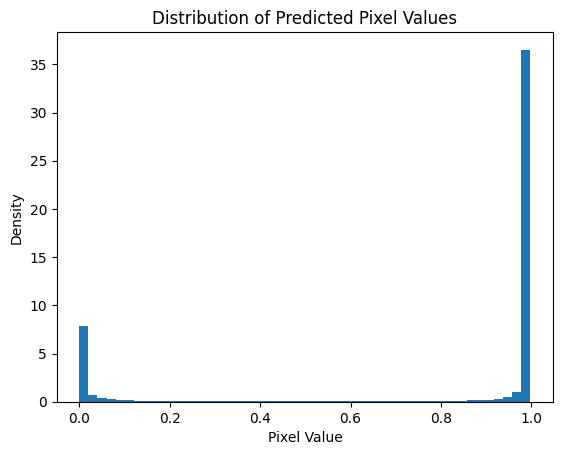

In [31]:
import torch
import numpy as np
import matplotlib.pyplot as plt


model.eval()

all_preds = []

with torch.no_grad():
    for images, _ in val_loader:
        images = images.to(device)
        preds = model(images)
        all_preds.extend(preds.flatten().cpu().numpy())  # Flatten and move to CPU

all_preds_np = np.array(all_preds)

# Plot the histogram
plt.hist(all_preds_np, bins=50, density=True)
plt.title('Distribution of Predicted Pixel Values')
plt.xlabel('Pixel Value')
plt.ylabel('Density')
plt.show()


In [32]:
# dataset = GrainDataset(X_rg, Y_t)
# rg_val_loader = DataLoader(dataset,batch_size=16, shuffle=False)

from torchmetrics.functional import dice
from torchmetrics.functional import jaccard_index
def cal(threshold):
  total_jaccard_score = 0.0
  total_dice_score = 0.0
  total_num_samples = 0

  for images, masks in rg_val_loader:
      batch_size = images.size(0)  # Get the actual batch size
      total_num_samples += batch_size

      with torch.no_grad():
          images = images.to(device)
          masks = masks.to(device)

        # Forward pass
          preds = model(images)

          for ind in range(len(preds)):
              pred_tensor = (preds[ind] > threshold).float()
              gt_tensor = masks[ind].to(torch.int64)

              dice_score = dice(pred_tensor, gt_tensor)
              total_dice_score += dice_score.item()

              jaccard_score = jaccard_index(pred_tensor, gt_tensor, task='binary')
              total_jaccard_score += jaccard_score.item()

  average_dice_score = total_dice_score / total_num_samples
  average_jaccard_score = total_jaccard_score / total_num_samples

  print(f"Threshold: {threshold}")
  print(f"Total Number samples: {total_num_samples}")
  print(f"Average Dice Score: {average_dice_score}")
  print(f"Average Jaccard Index: {average_jaccard_score}")

In [33]:
for i in np.arange(0.0, 1.1, 0.1):
    cal(i)

Threshold: 0.0
Total Number samples: 48
Average Dice Score: 0.86243728424112
Average Jaccard Index: 0.7585034022728602
Threshold: 0.1
Total Number samples: 48
Average Dice Score: 0.9098510456581911
Average Jaccard Index: 0.835062296440204
Threshold: 0.2
Total Number samples: 48
Average Dice Score: 0.9102979054053625
Average Jaccard Index: 0.8358245690663656
Threshold: 0.30000000000000004
Total Number samples: 48
Average Dice Score: 0.910474419593811
Average Jaccard Index: 0.8361261412501335
Threshold: 0.4
Total Number samples: 48
Average Dice Score: 0.910539956142505
Average Jaccard Index: 0.836238710830609
Threshold: 0.5
Total Number samples: 48
Average Dice Score: 0.9105679169297218
Average Jaccard Index: 0.8362871843079726
Threshold: 0.6000000000000001
Total Number samples: 48
Average Dice Score: 0.9105607680976391
Average Jaccard Index: 0.8362762543062369
Threshold: 0.7000000000000001
Total Number samples: 48
Average Dice Score: 0.9104630028208097
Average Jaccard Index: 0.836118072